Code for Week 3 Lecture 2: Computing System Response

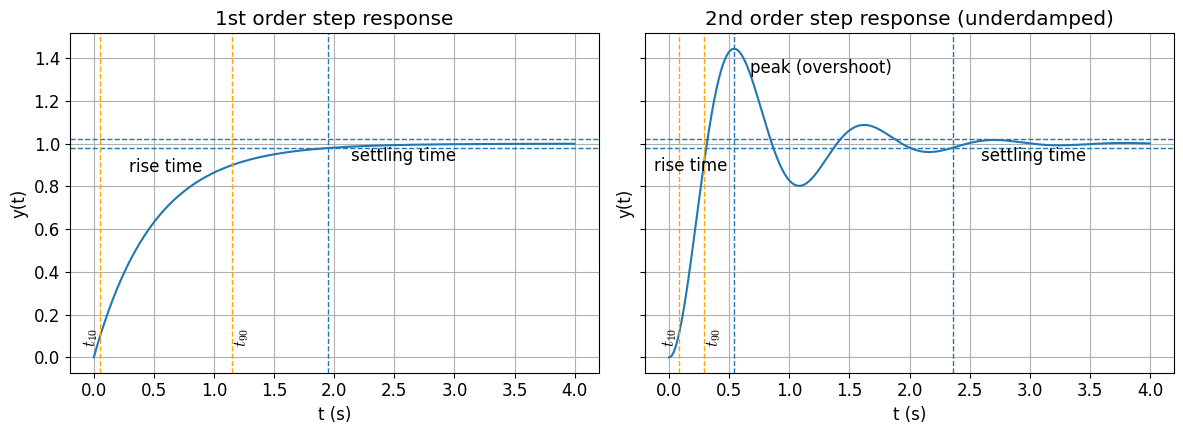

In [42]:
""" 
This code is largely AI generated but it has been verified for accuracy.
The prompt that was used clearly described the approach to compute the metrics.

"""
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import matplotlib 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['mathtext.fontset'] = 'cm'

def first_crossing_time(t, y, level):
    """Earliest time when y(t) crosses 'level' from below."""
    idx = np.where(y >= level)[0]
    if len(idx) == 0:
        return np.nan
    i = idx[0]
    if i == 0:
        return t[0]
    # linear interpolation between i-1 and i
    t0, t1 = t[i-1], t[i]
    y0, y1 = y[i-1], y[i]
    if y1 == y0:
        return t1
    return t0 + (level - y0) * (t1 - t0) / (y1 - y0)

def settling_time(t, y, y_final, tol=0.02):
    """Smallest ts such that |y(t)-y_final| <= tol*|y_final| for all t>=ts."""
    band = tol * (abs(y_final) if abs(y_final) > 1e-12 else 1.0)
    err = np.abs(y - y_final)
    outside = err > band
    if not np.any(outside):
        return t[0]
    last_outside = np.where(outside)[0][-1]
    if last_outside >= len(t) - 1:
        return np.nan
    return t[last_outside + 1]

def step_metrics(t, y, tol=0.02):
    y_final = y[-1]
    t10 = first_crossing_time(t, y, 0.1 * y_final)
    t90 = first_crossing_time(t, y, 0.9 * y_final)
    tr = t90 - t10
    ts = settling_time(t, y, y_final, tol=tol)
    ymax = np.max(y)
    tp = t[np.argmax(y)]
    Mp = (ymax - y_final) / y_final if abs(y_final) > 1e-12 else np.nan
    return dict(y_final=y_final, t10=t10, t90=t90, tr=tr, ts=ts, ymax=ymax, tp=tp, Mp=Mp)

# First-order: G1(s) = 1/(tau s + 1)
tau = 0.5
G1 = ct.tf([1], [tau, 1])

# Second-order: G2(s) = wn^2 / (s^2 + 2 zeta wn s + wn^2)
wn = 6.0
zeta = 0.25
G2 = ct.tf([wn**2], [1, 2*zeta*wn, wn**2])

# Time vector (long enough to settle)
t = np.linspace(0, 4.0, 4000)

# Step responses
t1, y1 = ct.step_response(G1, T=t)
t2, y2 = ct.step_response(G2, T=t)

# Compute metrics
m1 = step_metrics(t1, y1, tol=0.02)
m2 = step_metrics(t2, y2, tol=0.02)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

def annotate_step(ax, t, y, m, title):
    ax.plot(t, y)
    ax.set_title(title)
    ax.set_xlabel("t (s)")
    ax.set_ylabel("y(t)")
    ax.grid(True)

    yF = m["y_final"]

    # 2% settling band
    band = 0.02 * (abs(yF) if abs(yF) > 1e-12 else 1.0)
    ax.axhline(yF + band, linestyle="--", linewidth=1)
    ax.axhline(yF - band, linestyle="--", linewidth=1)

    # Rise time markers: t10 and t90
    if np.isfinite(m["t10"]):
        ax.axvline(m["t10"], linestyle="--", linewidth=1, color='orange')
        ax.text(m["t10"], 0.05 * yF, "$t_{10}$", rotation=90, va="bottom", ha="right")
    if np.isfinite(m["t90"]):
        ax.axvline(m["t90"], linestyle="--", linewidth=1, color='orange')
        ax.text(m["t90"], 0.05 * yF, "$t_{90}$", rotation=90, va="bottom", ha="left")
        # Label rise time (between t10 and t90)
        mid = 0.5 * (m["t10"] + m["t90"])
        ax.text(mid, 0.85 * yF, "rise time", ha="center", va="bottom")

    # Settling time marker
    if np.isfinite(m["ts"]):
        ax.axvline(m["ts"], linestyle="--", linewidth=1)
        ax.text(1.1*m["ts"], 0.9 * yF, "settling time", rotation=00, va="bottom", ha="left")

    # Overshoot marker (only meaningful if Mp > 0)
    if np.isfinite(m["Mp"]) and m["Mp"] > 1e-3:
        ax.axvline(m["tp"], linestyle="--", linewidth=1)
        ax.text(1.25*m["tp"], 0.91*m["ymax"], "peak (overshoot)", rotation=0, va="bottom", ha="left")

annotate_step(axes[0], t1, y1, m1, "1st order step response")
annotate_step(axes[1], t2, y2, m2, "2nd order step response (underdamped)")

fig.tight_layout()
fig.savefig("step_response.png", dpi=300)
plt.show()


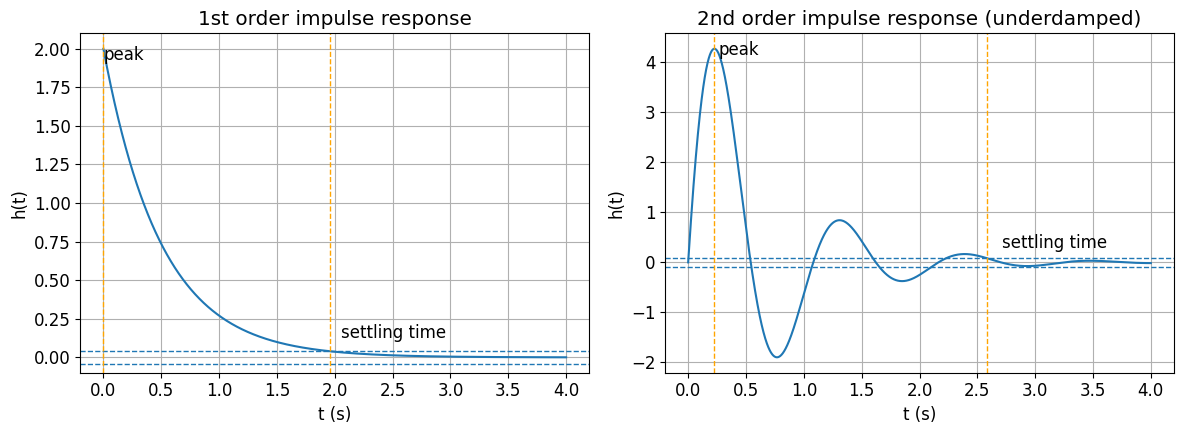

In [43]:
def impulse_metrics(t, y, tol=0.02):
    """
    Impulse/Disturbance metrics:
    - peak magnitude and time-to-peak (using absolute value)
    - settling time to a band around 0 (absolute tolerance = tol * peak_mag)
    """
    y_abs = np.abs(y)
    peak_mag = np.max(y_abs)
    tp = t[np.argmax(y_abs)]
    if peak_mag < 1e-12:
        return dict(peak_mag=0.0, tp=np.nan, ts=np.nan)

    band = tol * peak_mag
    outside = y_abs > band
    if not np.any(outside):
        ts = t[0]
    else:
        last_outside = np.where(outside)[0][-1]
        ts = np.nan if last_outside >= len(t) - 1 else t[last_outside + 1]

    return dict(peak_mag=peak_mag, tp=tp, ts=ts)



# -------------------------
# IMPULSE RESPONSE FIGURE
# -------------------------
t1i, h1 = ct.impulse_response(G1, T=t)
t2i, h2 = ct.impulse_response(G2, T=t)

im1 = impulse_metrics(t1i, h1, tol=0.02)
im2 = impulse_metrics(t2i, h2, tol=0.02)

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4.5), sharey=False)

def annotate_impulse(ax, t, h, im, title):
    ax.plot(t, h)
    ax.set_title(title)
    ax.set_xlabel("t (s)")
    ax.set_ylabel("h(t)")
    ax.grid(True)

    peak = im["peak_mag"]
    if peak < 1e-12:
        return

    # 2% band around 0 based on peak magnitude
    band = 0.02 * peak
    ax.axhline(+band, linestyle="--", linewidth=1)
    ax.axhline(-band, linestyle="--", linewidth=1)

    # Peak time marker
    if np.isfinite(im["tp"]):
        ax.axvline(im["tp"], linestyle="--", linewidth=1, color="orange")
        ax.text(1.15*im["tp"], 0.95*np.max(h), "peak", rotation=0, va="bottom", ha="left")

    # Settling time marker (when response stays within +/- band)
    if np.isfinite(im["ts"]):
        ax.axvline(im["ts"], linestyle="--", linewidth=1, color="orange")
        ax.text(1.05*im["ts"], 0.05*np.max(h), "settling time", rotation=0, va="bottom", ha="left")

    # "ringiness": label damped period if underdamped (approx from successive zero-crossings/peaks is possible,
    # but here we just label that oscillations are at omega_d for 2nd-order case in lecture text.
    # if "2nd order" in title:
    #     ax.text(0.65*t[-1], 0.85*np.max(h), "ringing", ha="left", va="bottom")

annotate_impulse(axes2[0], t1i, h1, im1, "1st order impulse response")
annotate_impulse(axes2[1], t2i, h2, im2, "2nd order impulse response (underdamped)")

fig2.tight_layout()
fig2.savefig("impulse_response.png", dpi=300)

plt.show()
